# GMDL, Project

In [39]:
import numpy as np
import torch
import torchvision
import itertools
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, models, transforms
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import lr_scheduler
import copy
import os
import random
from torch.autograd import Variable
from scipy.stats import norm
from skimage.filters import threshold_sauvola, threshold_otsu
from sklearn.metrics import confusion_matrix


## Data & Preprocessing

### Random seeds for reproducibility

In [40]:
def set_seeds(seed):
	torch.manual_seed(seed)
	np.random.seed(seed * 2)
	random.seed(seed * 3)

set_seeds(seed=123)

### Datasets, dataloaders, and transformations

In [ ]:
mnist_mean, mnist_std = 0.13, 0.31
cifar_mean, cifar_std = [0.49139968, 0.48215841, 0.44653091],[0.24703223, 0.24348513, 0.26158784]
fash_mean, fash_std = 0.286, 0.353

mnist_transform_train = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std),
    transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 1)),
    #transforms.RandomAffine(degrees=(-20, 20), translate=(0.01, 0.15), scale=(0.9, 1.1),fill=-1)
])

mnist_transform_test = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
])

fash_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(fash_mean, fash_std)
])

trainset_mnist = datasets.MNIST(
    root="data/MNIST",
    train=True,
    download=True,
    transform=mnist_transform_train
)

testset_mnist = datasets.MNIST(
    root="data/MNIST",
    train=False,
    download=True,
    transform=mnist_transform_test
)

testset_fash = datasets.FashionMNIST(
    root="data/FashionMNIST",
    train=False,
    download=True,
    transform=fash_transform
)


In [42]:
trainset_mnist, valset_mnist = torch.utils.data.random_split(dataset=trainset_mnist, lengths=[5/6, 1/6])

batch_size = 64
# data loaders
train_mnist_loader =  torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
test_mnist_loader =  torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_mnist_loader =  torch.utils.data.DataLoader(valset_mnist, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_fash_loader =  torch.utils.data.DataLoader(testset_fash, batch_size=batch_size,
                                           shuffle=True, num_workers=2)


In [43]:
cifar_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
    transforms.Grayscale()
])


testset_cifar = datasets.CIFAR10(
    root="data/CIFAR10",
    train=False,
    download=True,
    transform=cifar_transform
)

test_cifar_loader =  torch.utils.data.DataLoader(testset_cifar, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

testset_fash.targets[:] = 10
testset_cifar.targets = [10 for _ in testset_cifar.targets]


Files already downloaded and verified


### A subset of CIFAR10/FashionMNIST as OOD dataset

In [44]:
test_set_w_OOD = torch.utils.data.ConcatDataset([testset_mnist,
                                                testset_cifar,
                                                testset_fash
                                                 ])

test_loader_w_OOD =  torch.utils.data.DataLoader(test_set_w_OOD, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


## Auxiliary functions, definitions

In [45]:
def plot_images_grayscale(images, labels, mean, std, title=""):
    fig = plt.figure(figsize=(10, 10))
    pos = 1
    for i, img in enumerate(images):
        if i > 7:
            break
        fig.add_subplot(8, 8, pos)
        label = labels[i].cpu().numpy()
        img = img.cpu().numpy().transpose(1, 2, 0)
        img = std * img + mean
        plt.imshow(img, cmap='gray')
        plt.title(label, fontsize=20)
        plt.axis('off')
        pos += 1
    fig.suptitle(title, fontsize=16)
    plt.show()

def make_binary(img):
    T = threshold_otsu(img)
    binary = img > T
    return binary

def plot_images_binary(images, labels, mean, std, title=""):
    fig = plt.figure(figsize=(10, 10))
    pos = 1
    for i, img in enumerate(images):
        if i > 7:
            break
        fig.add_subplot(8, 8, pos)
        label = labels[i].cpu().numpy()
        img = img.cpu().numpy().transpose(1, 2, 0)
        img = std * img + mean
        img = make_binary(img)
        plt.imshow(img, cmap='gray')
        plt.title(label, fontsize=20)
        plt.axis('off')
        pos += 1
    fig.suptitle(title, fontsize=16)
    plt.show()

def plot_confusion_matrix(cm, classes=[i for i in range(11)], title='Confusion matrix', cmap=plt.cm.Blues):
    # We took this function from https://stackoverflow.com/questions/57329189/rendering-a-confusion-matrix
    # and manipulated it for better visualization.
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



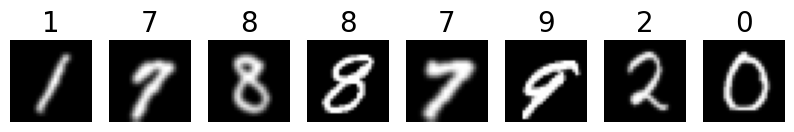

In [46]:
# visalize some images:
images, lables = next(iter(train_mnist_loader))
plot_images_grayscale(images, lables, mnist_mean, mnist_std)


(Some images are blurry because of the Gaussian filter.)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloaders={'train':train_mnist_loader, 'val': val_mnist_loader}
dataset_sizes = {'train': len(train_mnist_loader.dataset.indices), 'val':len(val_mnist_loader.dataset.indices)}

## Models

### Baseline model class

In [48]:
class ConvNet(nn.Module):
    def __init__(self, kernel_size=3):
        super(ConvNet, self).__init__()
        self.type = 'Conv'
        self.conv1 = nn.Conv2d(in_channels=1,
                              out_channels=10,
                              kernel_size=kernel_size,
                              stride=1,
                              padding=1,
                              )

        self.conv2 = nn.Conv2d(in_channels=10,
                              out_channels=20,
                              kernel_size=kernel_size,
                              stride=1,
                              padding=1,
                              )

        image_side = 28
        padding = 1
        image_side += -2*(kernel_size//2) + 2*padding
        image_side //= 2 # maxpool
        image_side += -2*(kernel_size//2) + 2*padding
        image_side //= 2 # maxpool

        self.fc1 = nn.Linear(20 * image_side**2, 64)
        self.fc2 = nn.Linear(64, 10)

        self.dropout2d = nn.Dropout2d(p=0.5)
        self.dropout05 = nn.Dropout(p=0.5)
        self.dropout02 = nn.Dropout(p=0.2)


    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        if self.training:
            self.dropout2d(x)
        # adaptive_avg_pool2d with output_size=1 = simple global avg pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        if self.training:
            self.dropout2d(x)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        if self.training:
            self.dropout05(x)
        x = F.relu(self.fc1(x))
        if self.training:
            self.dropout02(x)
        x = self.fc2(x)
        return x

### OSR model class

In [49]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Conv2d(1, 10, 5, stride=1, padding=1)
    self.fc1 = nn.Linear(1690, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
  def forward(self, x):
    x, max_indices = F.max_pool2d(F.relu(self.conv(x)), (2, 2), return_indices=True)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x, max_indices


class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(32, 64)
    self.fc2 = nn.Linear(64, 128)
    self.fc3 = nn.Linear(128, 1690)
    self.deconv = nn.ConvTranspose2d(10, 1, 5, stride=1, padding=1)

  def forward(self, x, max_indices):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = torch.unflatten(x, 1, (10,13,13))
    x = self.deconv(F.relu(F.max_unpool2d(x, kernel_size=(2, 2), indices=max_indices)))
    return x

In [50]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [51]:
class ML_Autoencoder(Autoencoder):
    def __init__(self):
        super(ML_Autoencoder, self).__init__()
        self.type = 'MLAE'
        self.n_classes = 11
        # Add classification head
        self.clf = ConvNet(5)

    def forward(self, x):
        encoded_vector, indices = self.encoder(x)
        recon = self.decoder(encoded_vector, indices)
        y = x.reshape((-1, 1, 28, 28))
        preds = self.clf(y)
        return recon, preds

## Training

In [52]:
def train_model(model, optimizer, criterion, autoencoder_criterion=None, num_epochs=30, device='cuda'):
    since = time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc_per_epoch = []
    validation_acc_per_epoch = []
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    model = model.to(device)
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = torch.Tensor(labels).to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    # logits: The raw predictions from the last layer
                    if model.type=='MLAE': # train both autoencoder and conv net
                        recon, logits = model(inputs)
                        _, preds = torch.max(logits, 1)
                        loss = autoencoder_criterion(recon, inputs) + criterion(logits, labels)

                    else:
                        logits = model(inputs)
                        _, preds = torch.max(logits, 1)
                        loss = criterion(logits, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            if phase == 'train':
                train_loss_per_epoch += [epoch_loss]
                train_acc_per_epoch += [epoch_acc.item()]

            # deep copy the model with the best accuracy based on the validation set
            if phase == 'val':
                val_loss_per_epoch +=[epoch_loss]
                validation_acc_per_epoch += [epoch_acc.item()]
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())


    # plot accuracy per epoch
    model.load_state_dict(best_model_wts)
    plt.plot([i for i in range(num_epochs)], train_acc_per_epoch, label="train")
    plt.plot([i for i in range(num_epochs)], validation_acc_per_epoch, label="val")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("accuracy per epoch")
    plt.legend()
    plt.show()
    # plot loss per epoch
    plt.plot([i for i in range(num_epochs)], train_loss_per_epoch, label="train")
    plt.plot([i for i in range(num_epochs)], val_loss_per_epoch, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("loss per epoch")
    plt.legend()
    plt.show()

    # load best model weights
    return model

In [53]:
conv_net = ConvNet(5)

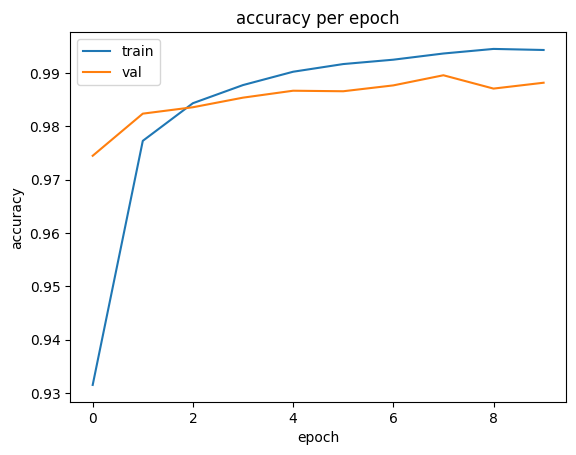

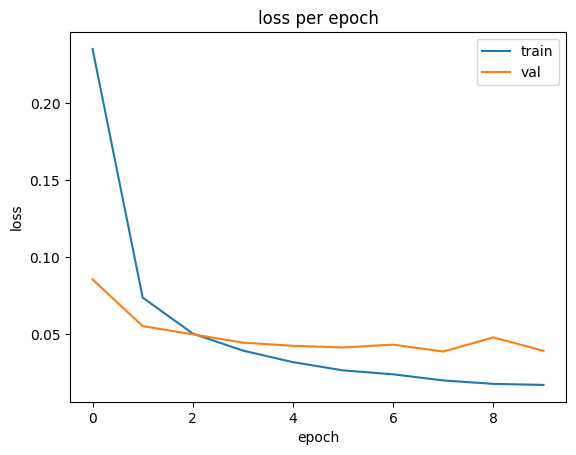

In [57]:
optimizer = optim.Adam(conv_net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
conv_net = train_model(conv_net, optimizer, criterion,device=device, num_epochs=10)

In [58]:
model = ML_Autoencoder()

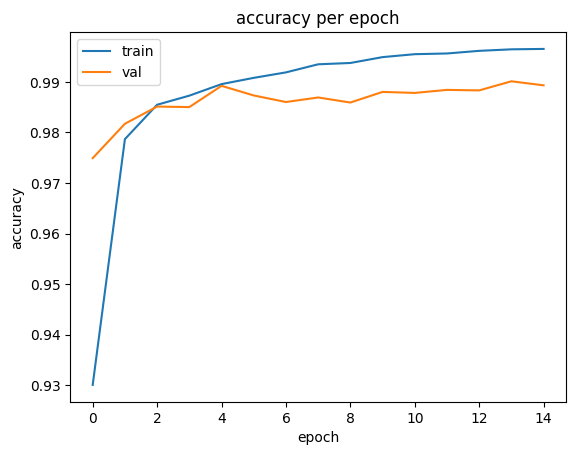

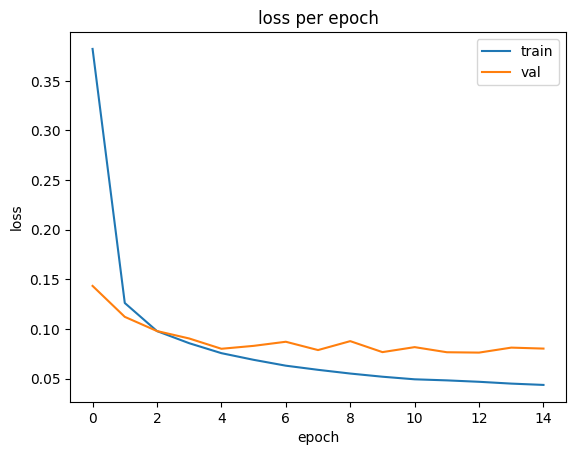

In [59]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
c1 = nn.CrossEntropyLoss()
c2 = nn.MSELoss()

model = train_model(model,optimizer, c1, autoencoder_criterion=c2,  device=device, num_epochs=15)

(After the training phase we choose the weights that performed best on the validation set.)

The model does not reach higher accuracy with more epochs so we decided to use 10 epochs for the classifier and 15 for the OSR model.

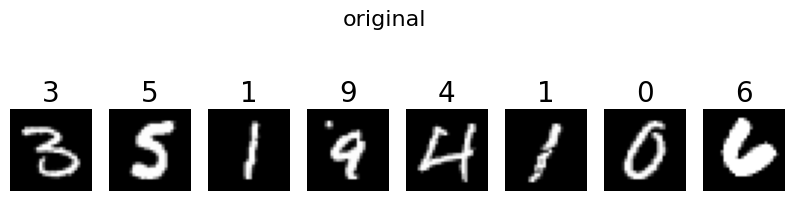

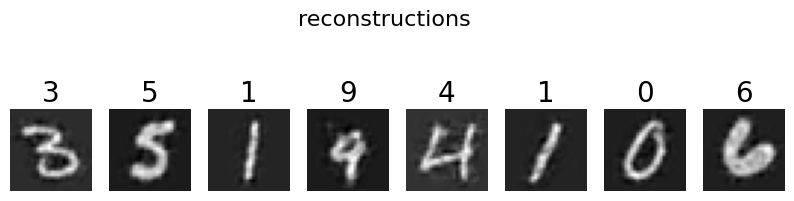

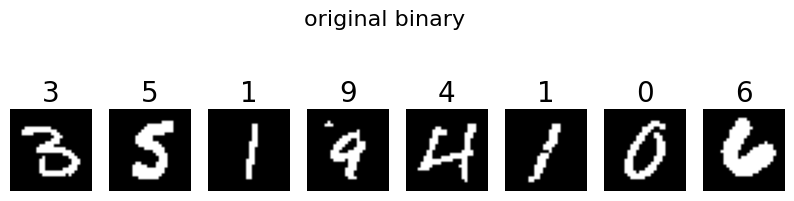

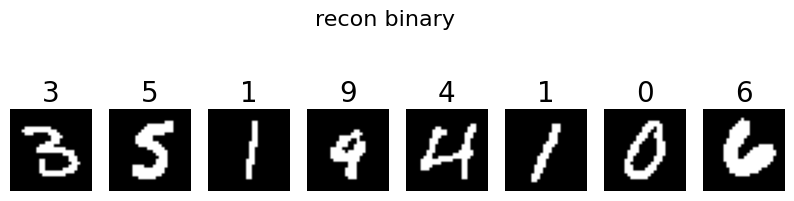

In [60]:
# visualize som images and reconstructions
test_images, test_labels = next(iter(test_mnist_loader))
test_images = test_images.to(device)
test_labels = test_labels.to(device)
model.eval()

recon, preds = model(test_images)
preds = torch.max(preds, 1)
preds=preds[1]

recon = recon.detach()
plot_images_grayscale(test_images, test_labels, mnist_mean, mnist_std, title="original")
plot_images_grayscale(recon, preds, mnist_mean, mnist_std, title="reconstructions")
plot_images_binary(test_images, test_labels, mnist_mean, mnist_std, title="original binary")
plot_images_binary(recon, preds, mnist_mean, mnist_std, title="recon binary")

## Evaluation

In [61]:
# This function compares between the original and reconstructed images in terms of norm and binary differencesbased on the otsu threshold.
def norms_and_diffs(model, loader):
    norms = []
    diffs = []
    model.eval()
    for inputs, labels  in iter(loader):
        inputs = Variable(inputs).to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        recons, probs = model(inputs)
        recons = recons.view(-1, 28, 28).detach().cpu().numpy()
        inputs = inputs.view(-1, 28, 28).detach().cpu().numpy()
        for i in range(len(inputs)):
            original_img = inputs[i]
            recon_img = recons[i]
            B = make_binary(recon_img)
            BO = make_binary(original_img)
            norms += [np.linalg.norm(original_img - recon_img)]
            diffs += [784 - np.sum(BO == B)]
    return norms, diffs

In [62]:
mnist_norms, mnist_diffs = norms_and_diffs(model, val_mnist_loader)

# These are the thresholds for the reconstructed images.
# If the difference between the reconstructed image and the original exceeds one of these thresholds,
# it is probably not in mnist
norms_thresh = np.mean(mnist_norms) + 3 * np.std(mnist_norms)
diffs_thresh = np.mean(mnist_diffs) + 3 * np.std(mnist_diffs)

In [63]:
def eval_model(model, test_loader, device='cude', binary=False):
  hidden_features = []
  correct_count, all_count = 0, 0
  plot = 1
  model.eval()
  final_labels, final_preds = torch.tensor([]), torch.tensor([])
  with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        if model.type == 'MLAE':
            recon,outputs = model(inputs)
            hidden_features.append(model.encoder(inputs)[0].detach())
            X = recon - inputs
            X = X.detach()
            norms = torch.linalg.norm(X, dim=( 2, 3)).view((-1))
            recon = recon.detach().cpu().numpy().reshape((-1, 28, 28))
            recon_binary = make_binary(recon)
            original_binary = make_binary(inputs.detach().cpu().numpy().reshape((-1, 28, 28)))
            diffs = np.sum(recon_binary != original_binary, axis=(1, 2))
            diffs = torch.from_numpy(diffs)
            _, preds = torch.max(outputs, 1)
            # change prediction if norm or diff is over the threshold
            preds[diffs > diffs_thresh] = 10
            preds[norms > norms_thresh] = 10
        else:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        if binary:
            preds[preds < 10] = 0
            preds[preds > 9] = 1
            labels[labels < 10] = 0
            labels[labels > 9] = 1
        final_labels = torch.cat((final_labels, labels.cpu()), 0)
        final_preds = torch.cat((final_preds, preds.cpu()), 0)
        correct_pred = torch.eq(labels, preds).cpu()
        correct_count += correct_pred.numpy().sum()
        all_count += len(labels)
  print("Number Of Images Tested =", all_count)
  print("\nModel Accuracy =", (correct_count/all_count))
  cf_matrix = confusion_matrix(final_labels, final_preds)
  plot_confusion_matrix(cf_matrix, classes=[i for i in range(1+int(final_labels.max()))])
  return final_preds, final_labels, hidden_features

### Baseline results

Number Of Images Tested = 10000

Model Accuracy = 0.989


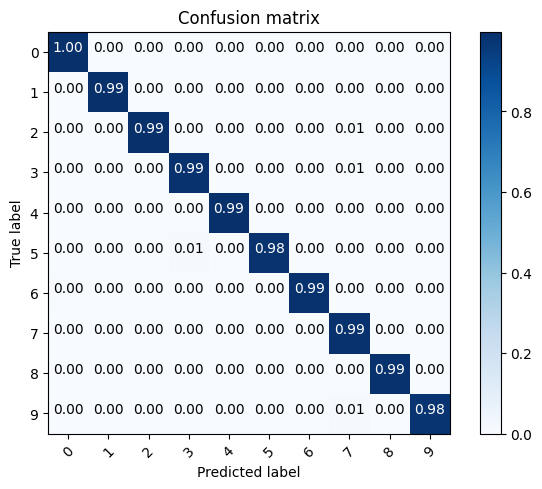

In [64]:
_ = eval_model(conv_net, test_mnist_loader, device=device)

### OOD results (0 = in mnist; 1 = OOD)

Number Of Images Tested = 30000

Model Accuracy = 0.9911333333333333


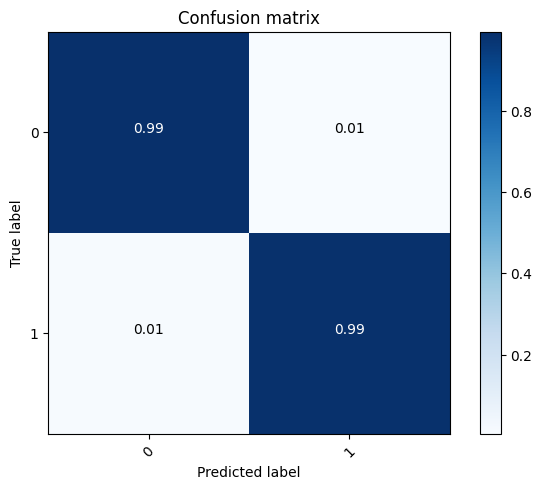

In [65]:
_ = eval_model(model, test_loader_w_OOD, device=device, binary=True)

### OSR results (0-9 = labels; 10 = OOD)

Number Of Images Tested = 30000

Model Accuracy = 0.9879333333333333


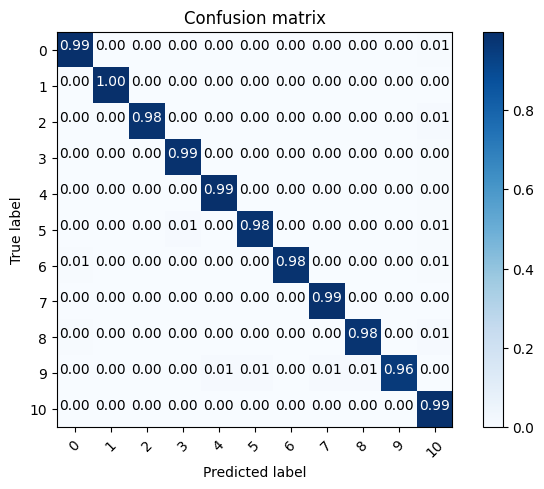

In [66]:
final_preds, _, hidden_features = eval_model(model, test_loader_w_OOD, device=device, binary=False)

In [67]:
fash_norms, fash_diffs = norms_and_diffs(model, test_fash_loader)
cifar_norms, cifar_diffs = norms_and_diffs(model, test_cifar_loader)

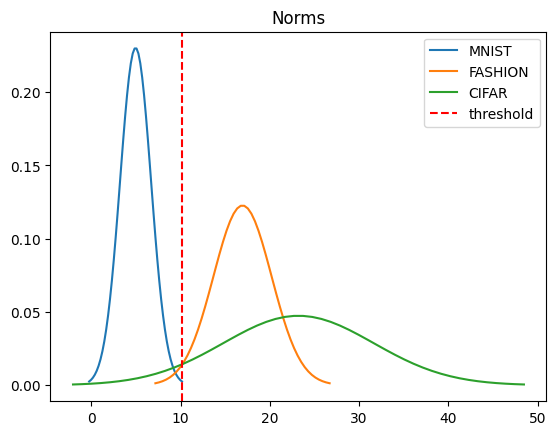

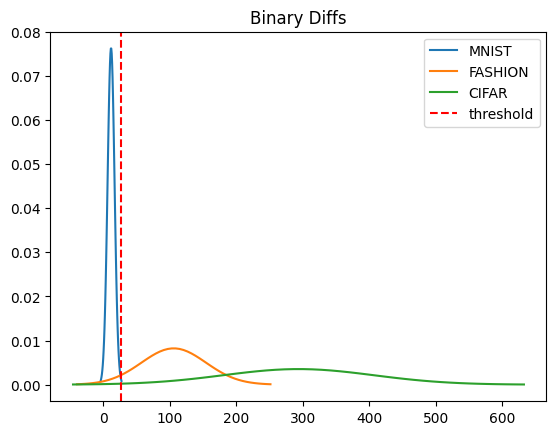

In [68]:
def plot_gaussian(mean, std, label=""):
    X = np.linspace(mean- 3 * std, mean+3*std, 50)
    plt.plot(X, norm.pdf(X, mean, std), label=label)

plot_gaussian(np.mean(mnist_norms), np.std(mnist_norms), label="MNIST")
plot_gaussian(np.mean(fash_norms), np.std(fash_norms), label="FASHION")
plot_gaussian(np.mean(cifar_norms), np.std(cifar_norms), label="CIFAR")
plt.axvline(norms_thresh, ls='--', color='r', label="threshold")
plt.legend()
plt.title("Norms")
plt.show()

plot_gaussian(np.mean(mnist_diffs), np.std(mnist_diffs), label="MNIST")
plot_gaussian(np.mean(fash_diffs), np.std(fash_diffs), label="FASHION")
plot_gaussian(np.mean(cifar_diffs), np.std(cifar_diffs), label="CIFAR")
plt.axvline(diffs_thresh,ls='--', color='r', label="threshold")
plt.legend()
plt.title("Binary Diffs")
plt.show()

In [69]:
torch.save(model.state_dict(), "./ML_autoencoder_W.pth")
torch.save(conv_net.state_dict(), "./conv_net_W.pth")

### t-SNE visualization of embedded layer of the test data

In [70]:
from sklearn.manifold import TSNE
from torchvision.models.feature_extraction import create_feature_extractor

model.eval()
with torch.no_grad():
    tsned_embedded_points = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(torch.cat(hidden_features).cpu())



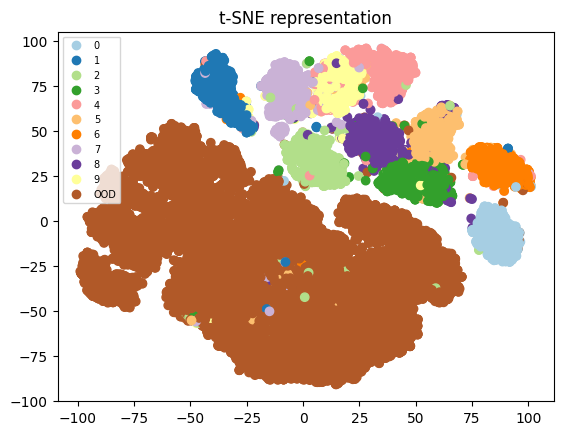

In [71]:
hidden_scatter  = plt.scatter(tsned_embedded_points[:,0], tsned_embedded_points[:,1], c=final_preds, cmap="Paired")
handles, _ = hidden_scatter.legend_elements()
legend = plt.legend(handles = handles, labels = [*range(0,10), "OOD"],fontsize="7")
plt.title("t-SNE representation")
plt.show()